In [13]:
import requests
import json
import sqlite3
from sqlite3 import Error
import pandas as pd
from matplotlib import pyplot as plt

KEY = "518e72a11de080028921e78aba2a102c" 
URL_KEY = "&api_key=" + KEY + "&file_type=json"
URL_BASE = "https://api.stlouisfed.org/fred/"

In [21]:
#Scaricare tutte le categorie a partire da una categoria data 
#(la struttura è ad albero e la categoria root ha id=0)

def get_category(url_base, url_key, id):
    try:
        r = requests.get(URL_BASE + "category?category_id=" + str(id) + URL_KEY)
        check = r.status_code
        if check != 200:
            print("Wrong request\n")
            exit()
    except requests.ConnectionError:
        print("No internet connection\n")
        exit()
    return r

#Scaricare tutti i titoli e gli id delle serie
#da una categoria data e salvarli su un db (es. sqlite) 

def get_serie(url_base, url_key, id):
    try:
        r = requests.get(URL_BASE + "category/series?category_id=" + str(id) + URL_KEY)
        check = r.status_code
        if check != 200:
            print("Wrong request\n")
            exit()
    except requests.ConnectionError:
        print("No internet connection\n")
        exit()
    return r

#Scaricare le osservabili da una serie data e salvarli su un db

def get_observation(url_base, url_key, id):
    try:
        r = requests.get(URL_BASE + "series/observations?series_id=" + id + URL_KEY)
        check = r.status_code
        if check != 200:
            print("Wrong request\n")
            exit()
    except requests.ConnectionError:
        print("No internet connection\n")
        exit()
    return r

r = get_observation(URL_BASE, URL_KEY, "MORTGAGE30US")
print(json.dumps(r.json(), indent=4))

{
    "realtime_start": "2022-01-20",
    "realtime_end": "2022-01-20",
    "observation_start": "1600-01-01",
    "observation_end": "9999-12-31",
    "units": "lin",
    "output_type": 1,
    "file_type": "json",
    "order_by": "observation_date",
    "sort_order": "asc",
    "count": 2652,
    "offset": 0,
    "limit": 100000,
    "observations": [
        {
            "realtime_start": "2022-01-20",
            "realtime_end": "2022-01-20",
            "date": "1971-04-02",
            "value": "7.33"
        },
        {
            "realtime_start": "2022-01-20",
            "realtime_end": "2022-01-20",
            "date": "1971-04-09",
            "value": "7.31"
        },
        {
            "realtime_start": "2022-01-20",
            "realtime_end": "2022-01-20",
            "date": "1971-04-16",
            "value": "7.31"
        },
        {
            "realtime_start": "2022-01-20",
            "realtime_end": "2022-01-20",
            "date": "1971-04-23",
        

In [26]:
#Insieme di funzioni per interagire con SQLite

def create_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        c = conn.cursor()
        c.execute('''
          CREATE TABLE IF NOT EXISTS series
          ([id] TEXT PRIMARY KEY, [title] TEXT)
          ''')
        c.execute('''
          CREATE TABLE IF NOT EXISTS observations
          ([date] TEXT PRIMARY KEY, [value] TEXT)
          ''')
        conn.commit()
        conn.close()

def insert_serie_db(db_file):

    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        r = get_serie(URL_BASE, URL_KEY, 3)
        series_number = len(r.json()["seriess"])
        for index in range(series_number):

            data = r.json()["seriess"][index]["id"], r.json()["seriess"][index]["title"]
            
            c = conn.cursor()
            
            #controlla se l'id è già presente, in caso ignora la insert
            c.execute("SELECT count(*) FROM series WHERE id = ?", (r.json()["seriess"][index]["id"],))
            check = c.fetchone()[0]
            if check != 0:
                continue
            
            #se id non presente, è inserita la relativa row
            sql = ''' INSERT INTO series (id, title) VALUES (?,?) '''
            c.execute(sql, data)
            conn.commit()
            
        conn.close()

def insert_observation_db(db_file):

    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        r = get_observation(URL_BASE, URL_KEY, "MORTGAGE30US")
        series_number = len(r.json()["observations"])
        for index in range(series_number):

            data = r.json()["observations"][index]["date"], r.json()["observations"][index]["value"]
            
            c = conn.cursor()
            
            #controlla se la date è già presente, in caso ignora la insert
            c.execute("SELECT count(*) FROM observations WHERE date = ?", (r.json()["observations"][index]["date"],))
            check = c.fetchone()[0]
            if check != 0:
                continue
            
            #se date non presente, è inserita la relativa row
            sql = ''' INSERT INTO observations (date, value) VALUES (?,?) '''
            c.execute(sql, data)
            conn.commit()
            
        conn.close()

def display_category_db():
    conn = None
    try:
        conn = sqlite3.connect("./database.db")
    except Error as e:
        print(e)
    finally:
        c = conn.cursor()
        
        c.execute('''
                  SELECT
                  s.id,
                  s.title
                  FROM series s
                  ''')
        
        df = pd.DataFrame(c.fetchall(), columns=['id','title'])
        conn.close()
        return df
        
def display_observation_db():
        conn = None
        try:
            conn = sqlite3.connect("./database.db")
        except Error as e:
            print(e)
        finally:
            c = conn.cursor()
            c.execute('''
                      SELECT
                      o.date,
                      o.value
                      FROM observations o
                      ''')

            df = pd.DataFrame(c.fetchall(), columns=['date','value'])
            conn.close()
            return df
        
create_db("./database.db")
insert_serie_db("./database.db")
insert_observation_db("./database.db")
display_category_db()

,id,title
0,CAPB00004S,Industrial Capacity: Manufacturing (SIC)
1,CAPB00004SQ,Industrial Capacity: Manufacturing (SIC)
2,CAPB50001S,Industrial Capacity: Total Index
3,CAPB50001SQ,Industrial Capacity: Total Index
4,CAPB5610CS,Industrial Capacity: Stage-of-Process: Crude P...
...,...,...
995,IPG3343S,Industrial Production: Manufacturing: Durable ...
996,IPG3343SQ,Industrial Production: Manufacturing: Durable ...
997,IPG33441A1N,Industrial Production: Semiconductors and rela...
998,IPG33441A1NQ,Industrial Production: Semiconductors and rela...


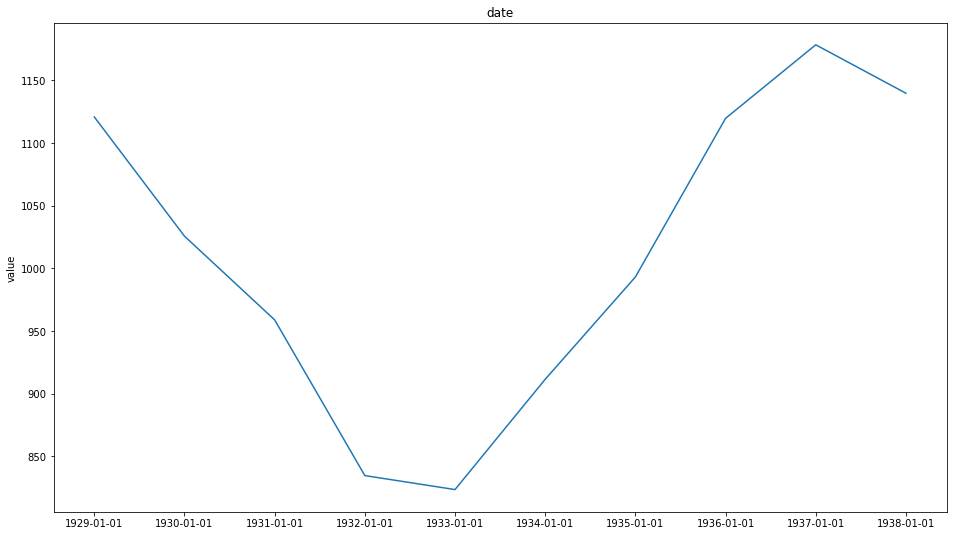

In [36]:
#Graficare l’andamento di una osservabile (se possibile)

def show():
    
    pd = display_observation_db()
    y = pd['date'].tolist()
    x = pd['value'].tolist()
    z = []
    for values in x:
        if(values == "."):
            values = 0
        z.append(float(values))
    
    plt.figure(figsize=(16,9)) 

    plt.plot(y[:10], z[:10]) 
    plt.ylabel("value") 
    plt.title("date") 
    plt.show()

show()
